# Imports and model initialization

In [86]:
%reload_ext autoreload
%autoreload

In [87]:
# !pip install kipoi
# !pip install kipoiseq
# !pip install pybedtools
# !pip uninstall -y kipoi_veff
# !pip install git+https://github.com/an1lam/kipoi-veff
# !pip install pyvcf
import csv
from operator import itemgetter
import math
import pickle

from Bio.motifs import pfm
import kipoi
from kipoi_interpret.importance_scores.ism import Mutation
from kipoiseq.dataloaders import SeqIntervalDl
import logomaker
from logomaker import Logo
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import cm
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
from tqdm import tqdm

from align import prob_sw
from motif_scores import kmer_mut_scores
from motif_scores import kmer_pwm_scores
from motif_scores import top_n_kmer_mut_scores
from motif_scores import top_n_kmer_pwm_scores
from pyx.one_hot import one_hot
from utils import INT_TO_BASES
from utils import one_hot_decode

In [88]:
!pwd

/home/stephenmalina/project/src


# Loading DNA sequence data

In [89]:
dl = SeqIntervalDl("../dat/50_random_seqs_2.bed", "../dat/hg19.fa", auto_resize_len=1000)
data = dl.load_all()

100%|██████████| 2/2 [00:00<00:00, 38.10it/s]


In [90]:
seqs = np.expand_dims(data['inputs'].transpose(0, 2, 1), 2).astype(np.float32)
seqs.shape

(50, 4, 1, 1000)

# Loading DeepSEA

In [91]:
import tensorflow as tf
print("TF version:", tf.__version__)
import torch
print("torch version:", torch.__version__)
from torch import nn
from torch.nn import functional as F

TF version: 1.15.0
torch version: 1.3.1


In [92]:
# df = kipoi.list_models()
# deepsea_models = df[df.model.str.contains("DeepSEA")]
# deepsea_models.head()

In [93]:
deepsea = kipoi.get_model("DeepSEA/predict", source="kipoi")
deepsea.model

Using downloaded and verified file: /home/stephenmalina/.kipoi/models/DeepSEA/predict/downloaded/model_files/weights/89e640bf6bdbe1ff165f484d9796efc7


Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): Dropout(p=0.5, inplace=False)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15):

In [94]:
CHROM_ACC_COL = 'HepG2_DNase_None'
# TF_COL = 'A549_CTCF_None'
TF_COL = 'HepG2_FOXA1_None'
relevant_cols = sorted([(i, label)
                        for i, label in enumerate(deepsea.schema.targets.column_labels)
                        if label in [CHROM_ACC_COL, TF_COL]])

In [95]:
deepsea.pipeline.predict_example().shape

100%|██████████| 1/1 [00:00<00:00, 26.23it/s]


(10, 919)

# Loading Predictions

In [96]:
import pickle
# pickle_file = "../dat/most_recent_sat_mut_results__drop_channel.pickle"
pickle_file = "../dat/most_recent_sat_mut_results__original_mc_dropout.pickle"

In [97]:
with open(pickle_file, 'rb') as f: np_preds = pickle.load(f)
print(np_preds.shape)
epochs, n_seqs, n_batches, batch_size, _ = np_preds.shape
np_preds.shape

(50, 50, 10, 301, 3)


(50, 50, 10, 301, 3)

In [98]:
def batches_needed(seq_len, batch_size, alpha_size=4):
    assert ((seq_len * (alpha_size-1)) % (batch_size-1)) == 0, seq_len * 3
    # alpha_size - 1 mutations per nt and then account for ref in each batch
    return (seq_len * (alpha_size-1)) // (batch_size-1)

def next_seq(it):
    return (np
            .expand_dims(next(it)["inputs"].transpose(0, 2, 1), 2)
            .astype(np.float32)
            .squeeze())

In [99]:
epochs, n_seqs, batch_size = 50, 25, 301
n_nts, _, seq_len = deepsea.schema.inputs.shape
it = dl.batch_iter(batch_size=1, num_workers=0, drop_last=False)
seqs = np.zeros((n_seqs, n_nts, seq_len))

for i in tqdm(range(min(n_seqs, len(it)))):
    seq = next_seq(it)
    if np.allclose(seq, .25): raise Exception("shouldn't have empty seqs")
    seqs[i, :, :] = seq
    
np_preds = np_preds[:, :n_seqs, :, :, :]

100%|██████████| 25/25 [00:00<00:00, 797.45it/s]


# Loading known FOXA1 motifs

In [100]:
with open('../dat/foxa1.pfm') as f: foxa1_motifs = pfm.read(f, 'pfm-four-rows')

In [101]:
def bio_to_np_pwm(pwm_map):
    motif_len = len(list(pwm_map.values())[0])
    np_pwm = np.zeros((len(pwm_map.keys()), motif_len))
    for i, base in INT_TO_BASES.items(): np_pwm[i, :] = pwm_map[base]
    return np_pwm
        

foxa1_pwm_maps = [motif.pwm for motif in foxa1_motifs]
foxa1_pwms = [bio_to_np_pwm(pwm_map) for pwm_map in foxa1_pwm_maps]

# Results & Analysis
## Computing summary statistics

In [102]:
log_uniform_prob = math.log(.05/(1-.05))
def compute_normalized_prob(prob, train_prob):
    # source: http://deepsea.princeton.edu/help/
    denom = 1+np.exp(-(np.log(prob/(1-prob))+log_uniform_prob-np.log(train_prob/(1-train_prob))))
    return 1 / denom

# Ratios and normalization formula drawn from here: http://deepsea.princeton.edu/media/help/posproportion.txt
tf_compute_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.02394)
chrom_acc_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.049791)

In [103]:
np_preds[:, :, :, :, 0] = chrom_acc_normalized_prob(np_preds[:, :, :, :, 0])
np_preds[:, :, :, :, 1] = compute_normalized_prob(np_preds[:, :, :, :, 1], 0.020508)
np_preds[:, :, :, :, 2] = compute_normalized_prob(np_preds[:, :, :, :, 2], 0.02394)

In [104]:
n_batches = np_preds.shape[2]
batch_size = np_preds.shape[3]
np_preds.shape

(50, 25, 10, 301, 3)

In [105]:
np_pred_means = np.mean(np_preds[:, :, :, :, :], axis=0)
np_pred_vars = np.var(np_preds, axis=0, dtype=np.float64)
np_pred_means.shape

(25, 10, 301, 3)

In [106]:
np_pred_mean_diffs = np_pred_means[:, :, 1:, :] - np_pred_means[:, :, 0:1, :] 
np_pred_mean_diffs.shape

(25, 10, 300, 3)

In [107]:
np_pred_covs = np.zeros((n_seqs, n_batches, batch_size, 2, 2, len(relevant_cols)))
for seq in range(n_seqs):
    for batch in range(n_batches):
        for col in range(len(relevant_cols)):
            ref_seq_preds = np_preds[:, seq, batch, 0, col]
            for mut in range(batch_size):
                mut_seq_preds = np_preds[:, seq, batch, mut, col]
                cov = np.cov(np.stack((ref_seq_preds, mut_seq_preds)), ddof=0) # 2x2, symmetric
                np_pred_covs[seq, batch, mut, :, :, col] = cov # off diag idx

In [108]:
np_pred_uncertainties = np.sqrt(
    np_pred_covs[:, :, 1:, 1, 1, :] + np_pred_covs[:, :, 1:, 0, 0, :] - 2 * np_pred_covs[:, :, 1:, 0, 1, :]
)

In [109]:
np_pred_mean_diffs = np_pred_mean_diffs.reshape(n_seqs, n_nts-1, -1, 3)
np_pred_mean_diffs.shape

(25, 3, 1000, 3)

In [112]:
kmers_mut_scores = kmer_mut_scores(seqs, np_pred_mean_diffs[:, :, :, 1], foxa1_pwms, max_k=11)

In [114]:
kmer_mut_scores_pickle_file = "../dat/kmer_mut_scores_all_seqs_pos_exs.pickle"

In [27]:
with open(kmer_mut_scores_pickle_file, 'wb') as f: pickle.dump(kmers_mut_scores, f)
# with open(kmer_mut_scores_pickle_file, 'rb') as f: kmers_mut_scores = pickle.load(f)

In [36]:
kmers_pwm_scores = kmer_pwm_scores(foxa1_pwms, max_k=11)

In [29]:
# kmer_pwm_scores_pickle_file = "../dat/kmer_pwm_scores_all_seqs.pickle"

In [30]:
# with open(kmer_pwm_scores_pickle_file, 'wb') as f: pickle.dump(kmers_pwm_scores, f)
# with open(kmer_pwm_scores_pickle_file, 'rb') as f: kmers_pwm_scores = pickle.load(f)

In [39]:
def pwm_key(pwm):
    return one_hot_decode(pwm)

pwm_seen = {pwm_key(pwm): 0 for pwm in foxa1_pwms}
for pwm in foxa1_pwms:
    pk = pwm_key(pwm)
    i = pwm_seen[pk]
    pwm_seen[pk] += 1
    mut_kmers, mut_scores = kmers_mut_scores[pk][i]
    pwm_kmers, pwm_scores = kmers_pwm_scores[pk][i]

    sorted_idxs = np.argsort(-1 * mut_scores)
    sorted_kmers = mut_kmers[sorted_idxs]
    sorted_mut_scores = mut_scores[sorted_idxs]
    sorted_pwm_scores = pwm_scores[sorted_idxs]
    corr = np.corrcoef(mut_scores, pwm_scores)
    print("Correlation between scores (%s, %d): %r" % (pk, i, corr[0, 1]))

dict_keys(['TGTTTACTTTG', 'TCCATGTTTACTTTG', 'ATGTAAACATGT'])
Correlation between scores (TGTTTACTTTG, 0): 0.24895490529989245
Correlation between scores (TGTTTACTTTG, 1): 0.24817808539735364
Correlation between scores (TCCATGTTTACTTTG, 0): 0.40827259403594784
Correlation between scores (ATGTAAACATGT, 0): 0.3757215498765087


Correlation between scores (TGTTTACTTTG, 0): 0.24895490529989245
Correlation between scores (TGTTTACTTTG, 1): 0.24817808539735364
Correlation between scores (TCCATGTTTACTTTG, 0): 0.40827259403594784
Correlation between scores (ATGTAAACATGT, 0): 0.3757215498765087


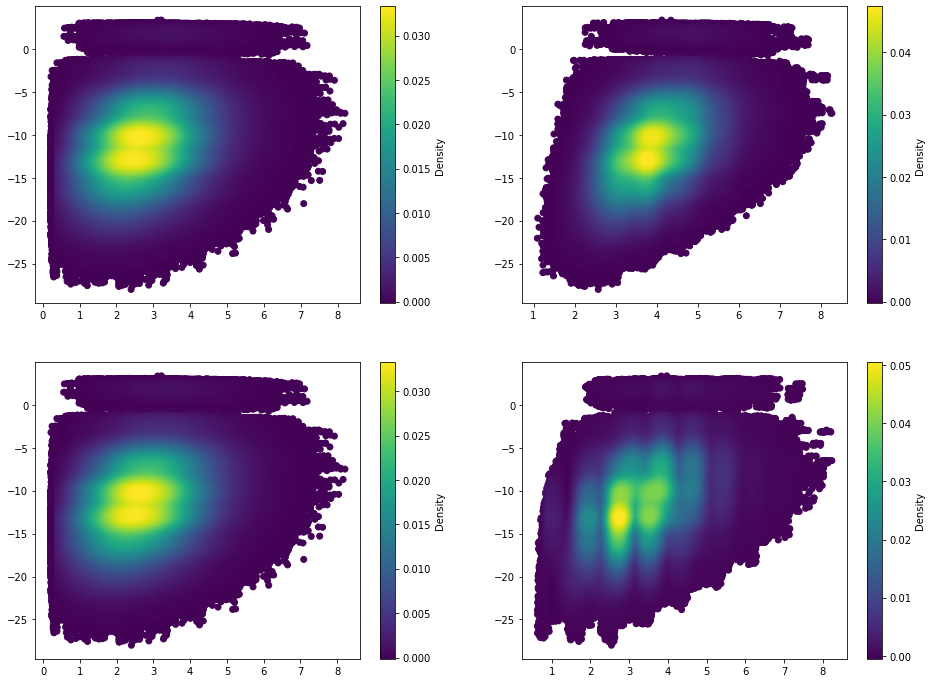

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, fig = fig, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    
    From: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

fig, axs = plt.subplots(2, len(foxa1_pwms) // 2, figsize=(16, 12))
pwm_seen = {pwm_key(pwm): 0 for pwm in foxa1_pwms}
for i, pwm in enumerate(foxa1_pwms):
    ax = axs[i % 2, i // 2]
    pk = pwm_key(pwm)
    i = pwm_seen[pk]
    pwm_seen[pk] += 1
    mut_kmers, mut_scores = kmers_mut_scores[pk][i]
    pwm_kmers, pwm_scores = kmers_pwm_scores[pk][i]

    sorted_idxs = np.argsort(-1 * mut_scores)
    sorted_kmers = mut_kmers[sorted_idxs]
    sorted_mut_scores = mut_scores[sorted_idxs]
    sorted_pwm_scores = pwm_scores[sorted_idxs]
    density_scatter(sorted_pwm_scores, sorted_mut_scores, fig=fig, ax=ax)
    corr = np.corrcoef(mut_scores, pwm_scores)
    print("Correlation between scores (%s, %d): %r" % (pk, i, corr[0, 1]))

In [67]:
def pwm_key(pwm):
    return one_hot_decode(pwm)

for n in [20, 50, 100, 500]:
    pwm_seen = {pwm_key(pwm): 0 for pwm in foxa1_pwms}
    for pwm in foxa1_pwms:
        pk = pwm_key(pwm)
        i = pwm_seen[pk]
        pwm_seen[pk] += 1
        mut_kmers, mut_scores = kmers_mut_scores[pk][i]
        pwm_kmers, pwm_scores = kmers_pwm_scores[pk][i]

        sorted_mut_idxs = np.argsort(mut_scores)[:n]
        sorted_pwm_idxs = np.argsort(pwm_scores)[:n]
        sorted_mut_kmers = [one_hot_decode(kmer) for kmer in mut_kmers[sorted_mut_idxs]]
        sorted_pwm_kmers = [one_hot_decode(kmer) for kmer in pwm_kmers[sorted_pwm_idxs]]
#         print(sorted_mut_kmers, mut_scores[sorted_mut_idxs])
#         print(sorted_pwm_kmers)
        matches = set(sorted_mut_kmers) & set(sorted_pwm_kmers)
        
        print("%d matches (n=%d, pwm=%s) \n\t top mut kmer: %s, top pwm kmer: %s" % (len(matches), n, pk, sorted_mut_kmers[0], sorted_pwm_kmers[0]))

0 matches (n=20, pwm=TGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCAACCGGACA
0 matches (n=20, pwm=TGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCAACCAGACA
0 matches (n=20, pwm=TCCATGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: GAACCCGGGGG
0 matches (n=20, pwm=ATGTAAACATGT) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCCGGCGGCCC
0 matches (n=50, pwm=TGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCAACCGGACA
0 matches (n=50, pwm=TGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCAACCAGACA
0 matches (n=50, pwm=TCCATGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: GAACCCGGGGG
0 matches (n=50, pwm=ATGTAAACATGT) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCCGGCGGCCC
0 matches (n=100, pwm=TGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCAACCGGACA
0 matches (n=100, pwm=TGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: CCAACCAGACA
0 matches (n=100, pwm=TCCATGTTTACTTTG) 
	 top mut kmer: GGGGCCCGCGC, top pwm kmer: GAACC